# Simulation Environments (last updated 21.05.24)
- **CU with local dataset**
- **Local dataset**: Unbalanced (3 classes/local dataset), Non-i.i.d., non-overapped samples
- **Channel**: Pathloss + Rayleigh fading
- **Power allocation**: Truncated channel inversion power allocation
- **Transmission type**: Analog Transmission with Compressed Sensing (AMP)

- CU and deivces have the same weight for the model update

In [1]:
!pip install PyWavelets
!pip install scikit-learn

     |████████████████████████████████| 4.4 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 23.1 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 74.0 MB/s eta 0:00:01


In [2]:
import os
import sys
sys.path.append('/workspace/shared/')
vp_path = os.path.abspath('vampyre-master/')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

In [3]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(self.conv2(x))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Default Setup *(Do not modify)*

In [5]:
lr = 0.1   # 0.1
batch_local = 10   # Size of local minibatch
E = 3 #3  # Local training epoch
epoch_max = 200
D = sum( p.numel() for p in net.parameters() if p.requires_grad)   # Number of parameters in model, 582,026 

noise_pow_dBm = -50 #-100
P_dBm = 20  #20
gamma = 0.1  # Target received SNR

sparse_energy = 0.9   # Sparse signal to original energy ratio
undersampl_fr = 0.1

# Measurement matrix generation
B = 1024    # Number of sub-channels

cell_radius = 150
density = 250/(np.pi*500**2) # 250 devices within the circle of radius 500
pathloss_exponent = 4

num_classes = 3   # Number of classes in local dataset
samples_avg_local = 200   # Average number of local samples
samples_CU = samples_avg_local   # Number of samples at CU

regul_coeff = 10e-5

### Variations in Setup *(Adjustable)*

In [6]:
P_dBm = 10 

### Load Simulation Setups

In [7]:
PATH_DEPLOYMENT = '../shared/simulation_setups/Deployment_within_550.npy'
PATH_TRAIN_DATASET = '../shared/simulation_setups/train_dataset.pth'
PATH_LOCAL_DATASET = '../shared/simulation_setups/localdataset_within_550.npy'

dev_deployment = np.load(PATH_DEPLOYMENT)        # Deployment of devices within 550 meters
trainset = torch.load(PATH_TRAIN_DATASET)         # Load training data and labels
x, y = trainset.values()
idx_localDB = np.load(PATH_LOCAL_DATASET, allow_pickle=True)        # Classified data indices

### Other System Parameters *(Do not modify)*

In [8]:
g_th = 0.5 * cell_radius ** -pathloss_exponent
noise_pow = 10**(noise_pow_dBm/10)
P = 10**(P_dBm/10)
Bt = int(B/undersampl_fr)    # Number of delivering parameters in a single OFDM symbol transmission
N = int(np.ceil(D/Bt))   # Number of transmit OFDM symbols
A = np.random.normal(0, 1/np.sqrt(Bt), (B, Bt) )
dev_num = np.sum((np.linalg.norm(dev_deployment, axis=1)<cell_radius))   # Number of devices
samples_local = [ len(idx_localDB[i]) for i in range(dev_num)]     # Number of samples at devices
samples_global = samples_CU+np.sum(samples_local)
print('Number of devices: ', dev_num)
print('Numnber of global samples: ', samples_global)

dev_dist = np.linalg.norm(dev_deployment[:dev_num], axis=1)
pathloss = dev_dist**-pathloss_exponent
print('Link distances: ', dev_dist[0:5])
print('Pathloss: ', pathloss[0:5])

permute_seq = np.random.permutation(N*Bt)    # Shuffling rule
permute_seq_inv = np.argsort(permute_seq)    # Inverse shuffling rule

Number of devices:  25
Numnber of global samples:  5278
Link distances:  [22.83855181 34.12266929 41.28552959 42.75910894 59.44096671]
Pathloss:  [3.67557892e-06 7.37612065e-07 3.44198173e-07 2.99147525e-07
 8.01044318e-08]


In [9]:
########### Data classification ##############
idx = []   # Empty list
for i in range(10):
    tmp = list((y==i).nonzero()[0])
    idx.append(tmp)
    
############ CU dataset ############
CU_x = torch.zeros(samples_CU,1, 28, 28)
CU_y = np.zeros(samples_CU, dtype=int)
CU_dataset = []
for i in range(10):
    CU_dataset += idx[i][:int(samples_CU/10)]
random.shuffle(CU_dataset)
    
for i, idx_CU in enumerate(CU_dataset):
    CU_x[i], CU_y[i] = x[idx_CU], y[idx_CU]

################### Test dataset ##################
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='../shared/MNIST_dataset/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=3)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

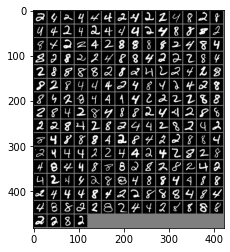

2, 4, 2, 4, 4, 4, 2, 4, 2, 2, 4, 8, 2, 8,


In [10]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = x[idx_localDB[0]]
labels = y[idx_localDB[0]]

# show images
first_row = int(np.sqrt(samples_local[0]))
imshow(torchvision.utils.make_grid(images, nrow=first_row))
# print labels
print(' '.join('%d,' % classes[labels[j]] for j in range(int(first_row))))

In [11]:
def model_localupdate(inputs, labels, net_org, E, batch_local, samples_local, lr):
    criterion = nn.CrossEntropyLoss()
    running_loss_local = 0.0
    acc_local = 0.0
    net_local = copy.deepcopy(net_org)   # deep copy of the network
    for _ in range(E):   # Local training epoch
        for b in range(int(np.ceil(samples_local/batch_local))):
            
            L2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in net_local.parameters():
                L2_reg = L2_reg + torch.norm(param, 2)
            
            start_idx = b*batch_local
            end_idx = b*batch_local+np.min([batch_local, samples_local-b*batch_local])
            outputs = net_local(inputs[start_idx:end_idx])
            loss = criterion(outputs, labels[start_idx:end_idx]) + regul_coeff*L2_reg   # 10e-4 L2-Regularization to prevent overfitting 
            net_local.zero_grad()
            loss.backward()
            
            if math.isnan(loss.item()): # Catch error
                print("outputs", outputs)
                print("inputs", inputs[start_idx:end_idx])
                w_sum = 0
                for i in net_local.parameters():
                    w_sum+=torch.sum(i)
                print('Sum of parameters: ', w_sum.item())
                ErrorOccur = input("Nan appears")
            
            with torch.no_grad():
                running_loss_local += loss.item()/(samples_local/batch_local)/E
                _, predicted = torch.max(outputs.data, 1)
                acc_local += (predicted == labels[start_idx:end_idx]).sum().item()
                for param_local in net_local.parameters():
                    param_local -= lr*param_local.grad
                    if math.isnan(torch.sum(param_local).item()):   # Catch error
                        print(param_local)
                        ErrorOccur = input("Nan appears")
                        
    return net_local, running_loss_local, acc_local          

In [12]:
def kaibin_power_allocation(P, N, B, delta_bar, h_pow, samples_local, samples_global, g_th):
    delta_pow_2d = (delta_bar**2).reshape((N, B))
    g = (1/h_pow).reshape((N,B)) 
    w = (samples_local/samples_global)**2
    tx = (1.0*(h_pow>=g_th)).reshape((N,B)) 
    #print(tx.sum())
    P_un = np.sum(w * delta_pow_2d * g * tx, 1)
    rho = P / P_un
    return rho

In [13]:
def sparsify(paramer_stack, N, Bt, energy_frac, sp_max = []):
    if len(sp_max)==0: sp_max = Bt
    syms = paramer_stack.reshape((N, Bt))
    eps = 10**(-10)   # Prevent dividing by zero
    pows = syms**2    # (N, Bt)
    desc_ordered_pows = np.flip(np.sort(pows, axis=1), axis=1)    # (N, Bt)
    pow_sum = np.sum(syms**2, axis=1).reshape((N,1))
    sp_tmp = np.sum(1.0*(np.cumsum(desc_ordered_pows/(pow_sum+eps), axis=1)<energy_frac), axis=1)    # N 
    sparsities =  np.minimum(np.maximum(sp_tmp, 1), sp_max)    # N
    threshold = np.take_along_axis(desc_ordered_pows, (sparsities.astype(int)).reshape((N,1)), axis=1)   # (N, 1)
    syms_sp = syms*(1.0*(syms**2>=threshold))    # Sum-power of significant entries account for 'energy_frac' of symbol power
    return sparsities, syms_sp    # N , NxBt 

In [14]:
def decompression_AMP(N, B, Bt, Y, rho, gamma, noise_pow, nz_means, nz_vars, sparsities_CU, A):
    param_recover_1d = np.zeros(N*Bt)
    est0_off = vp.estim.DiscreteEst(0, 1, (Bt,))    
    for s in range(N):
        #Ym = np.sqrt(rho/(gamma*noise_pow))*Y[s:s+B]
        Ym = np.sqrt(rho/(gamma*noise_pow))*Y[s*B:s*B+B]
        est0_on = vp.estim.GaussEst(nz_means[s] , nz_vars[s], (Bt,))
        est_list = [est0_off, est0_on]
        pz0 = np.array([1-sparsities_CU[s]/Bt, sparsities_CU[s]/Bt])
        est0 = vp.estim.MixEst(est_list, w=pz0, name='Input')
        Aop = vp.trans.MatrixLT(A, (Bt,))
        est1 = vp.estim.GaussEst(Ym, rho/gamma , (B, ), name='Output')
        
        solver = vp.solver.Gamp(est0, est1, Aop, hist_list=['z0', 'zvar0'], nit=20)
        solver.solve()
        
        #param_recover_1d[s:s+Bt] = solver.z0
        param_recover_1d[s*Bt:s*Bt+Bt] = solver.z0
    return param_recover_1d    

In [15]:
net_diff = Net()
net_diff.to(device)   # Storing network update
train_acc_history = np.zeros(epoch_max)
update_rho_history = np.zeros(epoch_max)

# Pre-Training in CU
#inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
#net, _, _ = model_localupdate(inputs, labels, net, init_E, batch_local, samples_CU, lr)


for epoch in range(epoch_max):  # loop over the dataset multiple times 
       
    ##################### Wireless Channel ###########################
    H_pow = pathloss.reshape(dev_num, 1)*np.random.exponential(1, (dev_num, B*N))    # Channel power gains, dev_num x BN
    
    ############# Update at the central unit ###############
    with torch.no_grad():   # Reset update
        for param_diff in net_diff.parameters():
            param_diff = torch.zeros_like(param_diff)
    
    inputs, labels = CU_x.to(device), torch.tensor(CU_y, dtype=torch.long).to(device)
    net_CU, running_loss_CU, acc_CU = model_localupdate(inputs, labels, net, E, batch_local, samples_CU, lr)
    
    with torch.no_grad():
        diff_stack = np.array([])
        for param_diff, param_org, param_CU in zip(net_diff.parameters(), net.parameters(), net_CU.parameters()):
            param_diff = param_CU-param_org
            param_org += (samples_CU/samples_global)*param_diff
            diff_stack = np.concatenate( (diff_stack, param_diff.view(-1).to("cpu").numpy()),axis=0)
    syms_CU_tmp = np.append(diff_stack, np.zeros(N*Bt-D))
    syms_CU = syms_CU_tmp[permute_seq]    # (NBt, )
    sparsities_CU, syms_CU_sp = sparsify(syms_CU, N, Bt, sparse_energy)
    nz_means = np.sum(syms_CU_sp, axis=1)/sparsities_CU    # Compute mean estimates of significant entries for each symbol 
    nz_vars = np.sum(syms_CU_sp**2, axis=1)/sparsities_CU - nz_means**2    # Compute variance estimates of significant entries for each symbol
    
    compress_syms_CU = np.matmul(A, np.transpose(syms_CU_sp))
    rho = np.sum(compress_syms_CU**2)/(N*B) + 10**(-10)   # Add small value to avoid dividing by zero     
    
    print('avg_update_SNR: %f' % (rho/noise_pow))
            
    total = samples_CU*E
    print('[epoch: %d, CU] loss: %.3f  accuracy: %.3f' % (epoch + 1, running_loss_CU, acc_CU/total))
        
    ########## Update at distributed devices #########
    running_loss = 0.0
    acc_tmp = 0.0
    total = 0
    X_sum = np.zeros(N*B)
    Y = np.zeros(N*B)
    syms_sum_tmp = np.zeros((N, Bt))
    
    delta_bar_all = {}
    
    for i in range(dev_num):   # get local dataset of i-th device; data is a list of [inputs, labels]
        inputs, labels = x[idx_localDB[i]].to(device), torch.tensor(y[idx_localDB[i]], dtype=torch.long).to(device)
        net_local, running_loss_local, acc_local = model_localupdate(inputs, labels, net, E, batch_local, samples_local[i], lr)
        running_loss += running_loss_local
        acc_tmp += acc_local
        
        with torch.no_grad():   
            local_param_stack = np.array([])
            for param_org, param_local in zip(net.parameters(), net_local.parameters()):
                local_param_stack = np.concatenate((local_param_stack, (param_local-param_org).view(-1).to("cpu").numpy()), 0)            
            
        syms_local_tmp = np.append(local_param_stack, np.zeros(N*Bt-D))
        syms_local = syms_local_tmp[permute_seq]
        sparsities_local, syms_local_sp = sparsify(syms_local, N, Bt, sparse_energy, sparsities_CU)
        compress_syms_local = np.matmul(A, np.transpose(syms_local_sp))   # (B, N)
        delta_bar = np.transpose(compress_syms_local).reshape(N*B)   # (NB, )
        delta_bar_all[i] = delta_bar
        
        # print statistics
        total += E*samples_local[i]
        num_proc = int(dev_num/10)
        if i % num_proc == num_proc-1:
            print('[epoch: %d, device: %3d] loss: %.3f  accuracy: %.3f' % (epoch + 1, i + 1, running_loss/num_proc, acc_tmp/total))
            running_loss = 0.0
            acc_tmp = 0.0
            total = 0
    
    for i in range(dev_num):
        delta_bar = delta_bar_all[i]        
        rho_i = kaibin_power_allocation(P, N, B, delta_bar, H_pow[i], samples_local[i], samples_global, g_th)
        
        rho_min = rho_i if i==0 else np.minimum(rho_min, rho_i)
        
            
    rho_min_ext = np.repeat(rho_min, B)
    
    for i in range(dev_num):
        delta_bar = delta_bar_all[i]
        
        tx_i = 1.0*(H_pow[i]>=g_th)
        
        X = samples_local[i]/samples_global*np.sqrt(rho_min_ext)*delta_bar*tx_i
        X_sum += X      
            
    Y = X_sum + np.sqrt(noise_pow)*np.random.randn(N*B)
    # Recover aggregated sparse signal with AMP
    param_recover_1d = decompression_AMP(N, B, Bt, Y, rho, gamma, noise_pow, nz_means, nz_vars, sparsities_CU, A)
    
    delta_hat = torch.tensor(param_recover_1d[permute_seq_inv]).to(device)
    idx_s = 0
    with torch.no_grad():
        for param_org in net.parameters():   # Update model at the main server
            tmp_param = delta_hat[idx_s:idx_s+param_org.numel()]
            param_org += tmp_param.view(param_org.size())
            idx_s += param_org.numel()
            
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images_tmp, labels = data
            images = images_tmp.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
            
    update_rho_history[epoch] = rho
    train_acc_history[epoch] = correct / total
    print('Accuracy for 10,000 test images: %.2f %%' % (100.0 * train_acc_history[epoch]))
    if train_acc_history[epoch] > 0.95: break
    
print('Training Finished')

avg_update_SNR: 2.114716
[epoch: 1, CU] loss: 1.900  accuracy: 0.360
[epoch: 1, device:   2] loss: 0.523  accuracy: 0.829
[epoch: 1, device:   4] loss: 0.762  accuracy: 0.747
[epoch: 1, device:   6] loss: 0.494  accuracy: 0.843
[epoch: 1, device:   8] loss: 0.718  accuracy: 0.737
[epoch: 1, device:  10] loss: 0.828  accuracy: 0.725
[epoch: 1, device:  12] loss: 0.758  accuracy: 0.751
[epoch: 1, device:  14] loss: 0.849  accuracy: 0.713
[epoch: 1, device:  16] loss: 0.685  accuracy: 0.762
[epoch: 1, device:  18] loss: 0.647  accuracy: 0.781
[epoch: 1, device:  20] loss: 0.908  accuracy: 0.668
[epoch: 1, device:  22] loss: 0.991  accuracy: 0.663
[epoch: 1, device:  24] loss: 0.688  accuracy: 0.795
Accuracy for 10,000 test images: 12.88 %
avg_update_SNR: 1.869389
[epoch: 2, CU] loss: 1.750  accuracy: 0.440
[epoch: 2, device:   2] loss: 0.595  accuracy: 0.823
[epoch: 2, device:   4] loss: 0.835  accuracy: 0.722
[epoch: 2, device:   6] loss: 0.536  accuracy: 0.837
[epoch: 2, device:   8] lo

avg_update_SNR: 1.070145
[epoch: 12, CU] loss: 0.517  accuracy: 0.863
[epoch: 12, device:   2] loss: 0.205  accuracy: 0.942
[epoch: 12, device:   4] loss: 0.430  accuracy: 0.880
[epoch: 12, device:   6] loss: 0.182  accuracy: 0.955
[epoch: 12, device:   8] loss: 0.402  accuracy: 0.880
[epoch: 12, device:  10] loss: 0.431  accuracy: 0.871
[epoch: 12, device:  12] loss: 0.225  accuracy: 0.926
[epoch: 12, device:  14] loss: 0.546  accuracy: 0.845
[epoch: 12, device:  16] loss: 0.395  accuracy: 0.894
[epoch: 12, device:  18] loss: 0.392  accuracy: 0.888
[epoch: 12, device:  20] loss: 0.305  accuracy: 0.931
[epoch: 12, device:  22] loss: 0.492  accuracy: 0.854
[epoch: 12, device:  24] loss: 0.373  accuracy: 0.906
Accuracy for 10,000 test images: 82.03 %
avg_update_SNR: 0.988160
[epoch: 13, CU] loss: 0.478  accuracy: 0.875
[epoch: 13, device:   2] loss: 0.214  accuracy: 0.941
[epoch: 13, device:   4] loss: 0.419  accuracy: 0.873
[epoch: 13, device:   6] loss: 0.166  accuracy: 0.954
[epoch: 1

[epoch: 22, device:  22] loss: 0.532  accuracy: 0.846
[epoch: 22, device:  24] loss: 0.192  accuracy: 0.957
Accuracy for 10,000 test images: 86.29 %
avg_update_SNR: 0.427549
[epoch: 23, CU] loss: 0.200  accuracy: 0.950
[epoch: 23, device:   2] loss: 0.176  accuracy: 0.946
[epoch: 23, device:   4] loss: 0.266  accuracy: 0.925
[epoch: 23, device:   6] loss: 0.158  accuracy: 0.957
[epoch: 23, device:   8] loss: 0.436  accuracy: 0.878
[epoch: 23, device:  10] loss: 0.648  accuracy: 0.840
[epoch: 23, device:  12] loss: 0.212  accuracy: 0.942
[epoch: 23, device:  14] loss: 0.549  accuracy: 0.838
[epoch: 23, device:  16] loss: 0.259  accuracy: 0.934
[epoch: 23, device:  18] loss: 0.579  accuracy: 0.844
[epoch: 23, device:  20] loss: 0.269  accuracy: 0.936
[epoch: 23, device:  22] loss: 0.580  accuracy: 0.841
[epoch: 23, device:  24] loss: 0.322  accuracy: 0.919
Accuracy for 10,000 test images: 86.43 %
avg_update_SNR: 0.398062
[epoch: 24, CU] loss: 0.188  accuracy: 0.953
[epoch: 24, device:   

[epoch: 33, device:  18] loss: 0.530  accuracy: 0.875
[epoch: 33, device:  20] loss: 0.207  accuracy: 0.946
[epoch: 33, device:  22] loss: 0.471  accuracy: 0.879
[epoch: 33, device:  24] loss: 0.220  accuracy: 0.944
Accuracy for 10,000 test images: 87.54 %
avg_update_SNR: 0.180229
[epoch: 34, CU] loss: 0.090  accuracy: 0.987
[epoch: 34, device:   2] loss: 0.223  accuracy: 0.945
[epoch: 34, device:   4] loss: 0.217  accuracy: 0.943
[epoch: 34, device:   6] loss: 0.193  accuracy: 0.954
[epoch: 34, device:   8] loss: 0.714  accuracy: 0.835
[epoch: 34, device:  10] loss: 0.329  accuracy: 0.905
[epoch: 34, device:  12] loss: 0.283  accuracy: 0.935
[epoch: 34, device:  14] loss: 0.362  accuracy: 0.902
[epoch: 34, device:  16] loss: 0.190  accuracy: 0.943
[epoch: 34, device:  18] loss: 0.549  accuracy: 0.871
[epoch: 34, device:  20] loss: 0.218  accuracy: 0.944
[epoch: 34, device:  22] loss: 0.513  accuracy: 0.854
[epoch: 34, device:  24] loss: 0.221  accuracy: 0.944
Accuracy for 10,000 test 

[epoch: 44, device:  14] loss: 0.569  accuracy: 0.859
[epoch: 44, device:  16] loss: 0.231  accuracy: 0.940
[epoch: 44, device:  18] loss: 0.570  accuracy: 0.880
[epoch: 44, device:  20] loss: 0.247  accuracy: 0.934
[epoch: 44, device:  22] loss: 0.716  accuracy: 0.806
[epoch: 44, device:  24] loss: 0.220  accuracy: 0.954
Accuracy for 10,000 test images: 87.96 %
avg_update_SNR: 0.065291
[epoch: 45, CU] loss: 0.039  accuracy: 1.000
[epoch: 45, device:   2] loss: 0.451  accuracy: 0.898
[epoch: 45, device:   4] loss: 0.379  accuracy: 0.903
[epoch: 45, device:   6] loss: 0.250  accuracy: 0.953
[epoch: 45, device:   8] loss: 0.681  accuracy: 0.834
[epoch: 45, device:  10] loss: 0.503  accuracy: 0.851
[epoch: 45, device:  12] loss: 0.498  accuracy: 0.897
[epoch: 45, device:  14] loss: 0.581  accuracy: 0.863
[epoch: 45, device:  16] loss: 0.215  accuracy: 0.941
[epoch: 45, device:  18] loss: 0.757  accuracy: 0.867
[epoch: 45, device:  20] loss: 0.240  accuracy: 0.938
[epoch: 45, device:  22] 

[epoch: 55, device:  10] loss: 0.642  accuracy: 0.841
[epoch: 55, device:  12] loss: 1.250  accuracy: 0.703
[epoch: 55, device:  14] loss: 0.683  accuracy: 0.856
[epoch: 55, device:  16] loss: 0.295  accuracy: 0.929
[epoch: 55, device:  18] loss: 0.657  accuracy: 0.844
[epoch: 55, device:  20] loss: 0.527  accuracy: 0.880
[epoch: 55, device:  22] loss: 0.917  accuracy: 0.753
[epoch: 55, device:  24] loss: 0.224  accuracy: 0.944
Accuracy for 10,000 test images: 88.12 %
avg_update_SNR: 0.027209
[epoch: 56, CU] loss: 0.022  accuracy: 1.000
[epoch: 56, device:   2] loss: 0.601  accuracy: 0.851
[epoch: 56, device:   4] loss: 0.853  accuracy: 0.794
[epoch: 56, device:   6] loss: 0.293  accuracy: 0.934
[epoch: 56, device:   8] loss: 0.984  accuracy: 0.778
[epoch: 56, device:  10] loss: 0.600  accuracy: 0.847
[epoch: 56, device:  12] loss: 1.274  accuracy: 0.717
[epoch: 56, device:  14] loss: 0.703  accuracy: 0.848
[epoch: 56, device:  16] loss: 0.271  accuracy: 0.929
[epoch: 56, device:  18] 

[epoch: 66, device:   6] loss: 0.630  accuracy: 0.856
[epoch: 66, device:   8] loss: 1.282  accuracy: 0.622
[epoch: 66, device:  10] loss: 0.689  accuracy: 0.818
[epoch: 66, device:  12] loss: 0.641  accuracy: 0.874
[epoch: 66, device:  14] loss: 0.834  accuracy: 0.813
[epoch: 66, device:  16] loss: 0.394  accuracy: 0.911
[epoch: 66, device:  18] loss: 0.696  accuracy: 0.835
[epoch: 66, device:  20] loss: 0.551  accuracy: 0.895
[epoch: 66, device:  22] loss: 0.779  accuracy: 0.797
[epoch: 66, device:  24] loss: 0.251  accuracy: 0.943
Accuracy for 10,000 test images: 88.13 %
avg_update_SNR: 0.013370
[epoch: 67, CU] loss: 0.015  accuracy: 1.000
[epoch: 67, device:   2] loss: 0.806  accuracy: 0.850
[epoch: 67, device:   4] loss: 0.810  accuracy: 0.823
[epoch: 67, device:   6] loss: 0.676  accuracy: 0.847
[epoch: 67, device:   8] loss: 1.288  accuracy: 0.622
[epoch: 67, device:  10] loss: 0.621  accuracy: 0.850
[epoch: 67, device:  12] loss: 0.605  accuracy: 0.879
[epoch: 67, device:  14] 

[epoch: 77, device:   2] loss: 0.927  accuracy: 0.816
[epoch: 77, device:   4] loss: 0.740  accuracy: 0.829
[epoch: 77, device:   6] loss: 0.813  accuracy: 0.811
[epoch: 77, device:   8] loss: 1.440  accuracy: 0.607
[epoch: 77, device:  10] loss: 1.018  accuracy: 0.743
[epoch: 77, device:  12] loss: 0.885  accuracy: 0.765
[epoch: 77, device:  14] loss: 1.055  accuracy: 0.771
[epoch: 77, device:  16] loss: 0.596  accuracy: 0.876
[epoch: 77, device:  18] loss: 1.291  accuracy: 0.649
[epoch: 77, device:  20] loss: 0.683  accuracy: 0.880
[epoch: 77, device:  22] loss: 1.104  accuracy: 0.711
[epoch: 77, device:  24] loss: 0.299  accuracy: 0.935
Accuracy for 10,000 test images: 88.22 %
avg_update_SNR: 0.007286
[epoch: 78, CU] loss: 0.011  accuracy: 1.000
[epoch: 78, device:   2] loss: 1.015  accuracy: 0.788
[epoch: 78, device:   4] loss: 0.894  accuracy: 0.793
[epoch: 78, device:   6] loss: 0.895  accuracy: 0.799
[epoch: 78, device:   8] loss: 1.411  accuracy: 0.613
[epoch: 78, device:  10] 

Accuracy for 10,000 test images: 88.29 %
avg_update_SNR: 0.004534
[epoch: 88, CU] loss: 0.009  accuracy: 1.000
[epoch: 88, device:   2] loss: 1.206  accuracy: 0.789
[epoch: 88, device:   4] loss: 0.961  accuracy: 0.776
[epoch: 88, device:   6] loss: 0.877  accuracy: 0.798
[epoch: 88, device:   8] loss: 1.521  accuracy: 0.611
[epoch: 88, device:  10] loss: 1.082  accuracy: 0.740
[epoch: 88, device:  12] loss: 0.644  accuracy: 0.866
[epoch: 88, device:  14] loss: 1.069  accuracy: 0.803
[epoch: 88, device:  16] loss: 0.581  accuracy: 0.883
[epoch: 88, device:  18] loss: 0.740  accuracy: 0.832
[epoch: 88, device:  20] loss: 0.699  accuracy: 0.888
[epoch: 88, device:  22] loss: 1.216  accuracy: 0.689
[epoch: 88, device:  24] loss: 0.334  accuracy: 0.923
Accuracy for 10,000 test images: 88.32 %
avg_update_SNR: 0.004337
[epoch: 89, CU] loss: 0.009  accuracy: 1.000
[epoch: 89, device:   2] loss: 0.913  accuracy: 0.823
[epoch: 89, device:   4] loss: 1.131  accuracy: 0.721
[epoch: 89, device:   

[epoch: 98, device:  22] loss: 0.995  accuracy: 0.764
[epoch: 98, device:  24] loss: 0.293  accuracy: 0.936
Accuracy for 10,000 test images: 88.42 %
avg_update_SNR: 0.002886
[epoch: 99, CU] loss: 0.007  accuracy: 1.000
[epoch: 99, device:   2] loss: 1.017  accuracy: 0.805
[epoch: 99, device:   4] loss: 1.245  accuracy: 0.675
[epoch: 99, device:   6] loss: 0.836  accuracy: 0.824
[epoch: 99, device:   8] loss: 1.593  accuracy: 0.607
[epoch: 99, device:  10] loss: 1.169  accuracy: 0.704
[epoch: 99, device:  12] loss: 0.610  accuracy: 0.879
[epoch: 99, device:  14] loss: 1.593  accuracy: 0.655
[epoch: 99, device:  16] loss: 0.562  accuracy: 0.883
[epoch: 99, device:  18] loss: 0.688  accuracy: 0.852
[epoch: 99, device:  20] loss: 0.742  accuracy: 0.869
[epoch: 99, device:  22] loss: 1.008  accuracy: 0.765
[epoch: 99, device:  24] loss: 0.294  accuracy: 0.937
Accuracy for 10,000 test images: 88.42 %
avg_update_SNR: 0.002780
[epoch: 100, CU] loss: 0.007  accuracy: 1.000
[epoch: 100, device: 

[epoch: 109, device:  12] loss: 0.796  accuracy: 0.795
[epoch: 109, device:  14] loss: 1.358  accuracy: 0.687
[epoch: 109, device:  16] loss: 0.664  accuracy: 0.845
[epoch: 109, device:  18] loss: 0.817  accuracy: 0.848
[epoch: 109, device:  20] loss: 0.837  accuracy: 0.847
[epoch: 109, device:  22] loss: 1.229  accuracy: 0.711
[epoch: 109, device:  24] loss: 0.298  accuracy: 0.933
Accuracy for 10,000 test images: 88.38 %
avg_update_SNR: 0.001952
[epoch: 110, CU] loss: 0.007  accuracy: 1.000
[epoch: 110, device:   2] loss: 1.152  accuracy: 0.788
[epoch: 110, device:   4] loss: 1.396  accuracy: 0.644
[epoch: 110, device:   6] loss: 0.879  accuracy: 0.792
[epoch: 110, device:   8] loss: 1.681  accuracy: 0.597
[epoch: 110, device:  10] loss: 1.283  accuracy: 0.674
[epoch: 110, device:  12] loss: 0.807  accuracy: 0.804
[epoch: 110, device:  14] loss: 1.427  accuracy: 0.683
[epoch: 110, device:  16] loss: 0.602  accuracy: 0.857
[epoch: 110, device:  18] loss: 0.775  accuracy: 0.842
[epoch: 

[epoch: 120, device:   2] loss: 1.102  accuracy: 0.813
[epoch: 120, device:   4] loss: 1.404  accuracy: 0.610
[epoch: 120, device:   6] loss: 0.956  accuracy: 0.773
[epoch: 120, device:   8] loss: 1.889  accuracy: 0.602
[epoch: 120, device:  10] loss: 1.285  accuracy: 0.681
[epoch: 120, device:  12] loss: 1.142  accuracy: 0.635
[epoch: 120, device:  14] loss: 1.795  accuracy: 0.535
[epoch: 120, device:  16] loss: 0.618  accuracy: 0.865
[epoch: 120, device:  18] loss: 0.923  accuracy: 0.841
[epoch: 120, device:  20] loss: 0.796  accuracy: 0.865
[epoch: 120, device:  22] loss: 1.297  accuracy: 0.668
[epoch: 120, device:  24] loss: 0.385  accuracy: 0.912
Accuracy for 10,000 test images: 88.34 %
avg_update_SNR: 0.001386
[epoch: 121, CU] loss: 0.006  accuracy: 1.000
[epoch: 121, device:   2] loss: 1.168  accuracy: 0.793
[epoch: 121, device:   4] loss: 1.422  accuracy: 0.596
[epoch: 121, device:   6] loss: 1.036  accuracy: 0.749
[epoch: 121, device:   8] loss: 1.768  accuracy: 0.580
[epoch: 

[epoch: 130, device:  20] loss: 0.852  accuracy: 0.858
[epoch: 130, device:  22] loss: 1.506  accuracy: 0.602
[epoch: 130, device:  24] loss: 0.409  accuracy: 0.914
Accuracy for 10,000 test images: 88.37 %
avg_update_SNR: 0.001051
[epoch: 131, CU] loss: 0.005  accuracy: 1.000
[epoch: 131, device:   2] loss: 1.185  accuracy: 0.805
[epoch: 131, device:   4] loss: 1.402  accuracy: 0.605
[epoch: 131, device:   6] loss: 0.932  accuracy: 0.798
[epoch: 131, device:   8] loss: 1.903  accuracy: 0.600
[epoch: 131, device:  10] loss: 1.590  accuracy: 0.555
[epoch: 131, device:  12] loss: 1.173  accuracy: 0.608
[epoch: 131, device:  14] loss: 1.434  accuracy: 0.687
[epoch: 131, device:  16] loss: 0.697  accuracy: 0.827
[epoch: 131, device:  18] loss: 0.780  accuracy: 0.856
[epoch: 131, device:  20] loss: 0.897  accuracy: 0.852
[epoch: 131, device:  22] loss: 1.345  accuracy: 0.668
[epoch: 131, device:  24] loss: 0.356  accuracy: 0.930
Accuracy for 10,000 test images: 88.37 %
avg_update_SNR: 0.0010

[epoch: 141, device:  10] loss: 1.675  accuracy: 0.550
[epoch: 141, device:  12] loss: 1.162  accuracy: 0.612
[epoch: 141, device:  14] loss: 2.129  accuracy: 0.415
[epoch: 141, device:  16] loss: 0.784  accuracy: 0.814
[epoch: 141, device:  18] loss: 0.962  accuracy: 0.837
[epoch: 141, device:  20] loss: 0.774  accuracy: 0.870
[epoch: 141, device:  22] loss: 1.453  accuracy: 0.631
[epoch: 141, device:  24] loss: 0.375  accuracy: 0.923
Accuracy for 10,000 test images: 88.43 %
avg_update_SNR: 0.000799
[epoch: 142, CU] loss: 0.005  accuracy: 1.000
[epoch: 142, device:   2] loss: 1.285  accuracy: 0.785
[epoch: 142, device:   4] loss: 1.521  accuracy: 0.613
[epoch: 142, device:   6] loss: 1.127  accuracy: 0.720
[epoch: 142, device:   8] loss: 1.954  accuracy: 0.617
[epoch: 142, device:  10] loss: 1.601  accuracy: 0.598
[epoch: 142, device:  12] loss: 1.153  accuracy: 0.616
[epoch: 142, device:  14] loss: 1.807  accuracy: 0.539
[epoch: 142, device:  16] loss: 0.748  accuracy: 0.813
[epoch: 

avg_update_SNR: 0.000639
[epoch: 152, CU] loss: 0.005  accuracy: 1.000
[epoch: 152, device:   2] loss: 1.285  accuracy: 0.771
[epoch: 152, device:   4] loss: 1.720  accuracy: 0.510
[epoch: 152, device:   6] loss: 1.314  accuracy: 0.631
[epoch: 152, device:   8] loss: 1.967  accuracy: 0.581
[epoch: 152, device:  10] loss: 1.638  accuracy: 0.576
[epoch: 152, device:  12] loss: 1.238  accuracy: 0.599
[epoch: 152, device:  14] loss: 1.873  accuracy: 0.521
[epoch: 152, device:  16] loss: 0.922  accuracy: 0.788
[epoch: 152, device:  18] loss: 0.940  accuracy: 0.835
[epoch: 152, device:  20] loss: 0.913  accuracy: 0.847
[epoch: 152, device:  22] loss: 1.327  accuracy: 0.682
[epoch: 152, device:  24] loss: 0.438  accuracy: 0.906
Accuracy for 10,000 test images: 88.37 %
avg_update_SNR: 0.000625
[epoch: 153, CU] loss: 0.005  accuracy: 1.000
[epoch: 153, device:   2] loss: 1.363  accuracy: 0.755
[epoch: 153, device:   4] loss: 1.468  accuracy: 0.592
[epoch: 153, device:   6] loss: 1.301  accuracy

[epoch: 162, device:  18] loss: 1.015  accuracy: 0.797
[epoch: 162, device:  20] loss: 1.386  accuracy: 0.646
[epoch: 162, device:  22] loss: 1.405  accuracy: 0.639
[epoch: 162, device:  24] loss: 0.419  accuracy: 0.921
Accuracy for 10,000 test images: 88.30 %
avg_update_SNR: 0.000510
[epoch: 163, CU] loss: 0.004  accuracy: 1.000
[epoch: 163, device:   2] loss: 1.327  accuracy: 0.784
[epoch: 163, device:   4] loss: 1.960  accuracy: 0.519
[epoch: 163, device:   6] loss: 1.084  accuracy: 0.727
[epoch: 163, device:   8] loss: 2.096  accuracy: 0.578
[epoch: 163, device:  10] loss: 1.858  accuracy: 0.482
[epoch: 163, device:  12] loss: 1.225  accuracy: 0.627
[epoch: 163, device:  14] loss: 1.735  accuracy: 0.643
[epoch: 163, device:  16] loss: 0.835  accuracy: 0.799
[epoch: 163, device:  18] loss: 1.257  accuracy: 0.766
[epoch: 163, device:  20] loss: 1.361  accuracy: 0.645
[epoch: 163, device:  22] loss: 1.421  accuracy: 0.621
[epoch: 163, device:  24] loss: 0.389  accuracy: 0.922
Accuracy

[epoch: 173, device:   8] loss: 2.182  accuracy: 0.584
[epoch: 173, device:  10] loss: 1.699  accuracy: 0.547
[epoch: 173, device:  12] loss: 1.265  accuracy: 0.630
[epoch: 173, device:  14] loss: 1.694  accuracy: 0.663
[epoch: 173, device:  16] loss: 0.883  accuracy: 0.786
[epoch: 173, device:  18] loss: 1.010  accuracy: 0.813
[epoch: 173, device:  20] loss: 1.298  accuracy: 0.672
[epoch: 173, device:  22] loss: 1.452  accuracy: 0.668
[epoch: 173, device:  24] loss: 0.441  accuracy: 0.912
Accuracy for 10,000 test images: 88.37 %
avg_update_SNR: 0.000415
[epoch: 174, CU] loss: 0.004  accuracy: 1.000
[epoch: 174, device:   2] loss: 1.328  accuracy: 0.797
[epoch: 174, device:   4] loss: 1.664  accuracy: 0.540
[epoch: 174, device:   6] loss: 1.211  accuracy: 0.676
[epoch: 174, device:   8] loss: 2.211  accuracy: 0.576
[epoch: 174, device:  10] loss: 1.777  accuracy: 0.522
[epoch: 174, device:  12] loss: 1.286  accuracy: 0.608
[epoch: 174, device:  14] loss: 2.113  accuracy: 0.461
[epoch: 

Accuracy for 10,000 test images: 88.38 %
avg_update_SNR: 0.000350
[epoch: 184, CU] loss: 0.004  accuracy: 1.000
[epoch: 184, device:   2] loss: 1.385  accuracy: 0.776
[epoch: 184, device:   4] loss: 1.546  accuracy: 0.569
[epoch: 184, device:   6] loss: 1.262  accuracy: 0.645
[epoch: 184, device:   8] loss: 2.271  accuracy: 0.594
[epoch: 184, device:  10] loss: 1.657  accuracy: 0.564
[epoch: 184, device:  12] loss: 1.209  accuracy: 0.617
[epoch: 184, device:  14] loss: 1.798  accuracy: 0.624
[epoch: 184, device:  16] loss: 1.116  accuracy: 0.735
[epoch: 184, device:  18] loss: 0.880  accuracy: 0.833
[epoch: 184, device:  20] loss: 1.257  accuracy: 0.694
[epoch: 184, device:  22] loss: 1.549  accuracy: 0.586
[epoch: 184, device:  24] loss: 0.416  accuracy: 0.927
Accuracy for 10,000 test images: 88.38 %
avg_update_SNR: 0.000344
[epoch: 185, CU] loss: 0.004  accuracy: 1.000
[epoch: 185, device:   2] loss: 1.591  accuracy: 0.739
[epoch: 185, device:   4] loss: 1.662  accuracy: 0.572
[epoch

[epoch: 194, device:  16] loss: 0.708  accuracy: 0.840
[epoch: 194, device:  18] loss: 1.476  accuracy: 0.726
[epoch: 194, device:  20] loss: 1.279  accuracy: 0.707
[epoch: 194, device:  22] loss: 1.310  accuracy: 0.719
[epoch: 194, device:  24] loss: 0.443  accuracy: 0.919
Accuracy for 10,000 test images: 88.38 %
avg_update_SNR: 0.000294
[epoch: 195, CU] loss: 0.004  accuracy: 1.000
[epoch: 195, device:   2] loss: 1.528  accuracy: 0.759
[epoch: 195, device:   4] loss: 1.557  accuracy: 0.607
[epoch: 195, device:   6] loss: 1.332  accuracy: 0.656
[epoch: 195, device:   8] loss: 2.259  accuracy: 0.579
[epoch: 195, device:  10] loss: 1.899  accuracy: 0.496
[epoch: 195, device:  12] loss: 1.307  accuracy: 0.618
[epoch: 195, device:  14] loss: 1.814  accuracy: 0.621
[epoch: 195, device:  16] loss: 0.832  accuracy: 0.796
[epoch: 195, device:  18] loss: 1.091  accuracy: 0.750
[epoch: 195, device:  20] loss: 1.216  accuracy: 0.749
[epoch: 195, device:  22] loss: 1.474  accuracy: 0.662
[epoch: 

In [16]:
from datetime import date
Date = '['+str(date.today())+']'
PATH_SIM = '../shared/results/Simulation_Env/'+Date+'Sim_CS_TCI_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save simulation environment
PATH_NET = '../shared/results/Network/'+Date+'Net_CS_TCI_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)+'.pth'   # save neural network
PATH_ACC = '../shared/results/Accuracy/'+Date+'Acc_CS_TCI_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save accuracy history
PATH_RHO = '../shared/results/RHO/'+Date+'RHO_CS_TCI_Acc'+str(correct/total)+'CmpRate'+str(undersampl_fr)+'Dmax'+str(cell_radius)+'CU'+str(samples_CU)+'P'+str(P)   # save SNR history

np.save(PATH_ACC, train_acc_history)
print(PATH_ACC+'.npy is saved')
np.savez(PATH_SIM, lr=lr, batch_local=batch_local, E=E, epoch_max=epoch, D=D, noise_pow_dBm=noise_pow_dBm, P_dBm=P_dBm, gamma=gamma, B=B, N=N, cell_radius=cell_radius, density=density, dev_num=dev_num, pathloss_exponent=pathloss_exponent, num_classes=num_classes, samples_avg_local=samples_avg_local, samples_local=samples_local, samples_CU=samples_CU, undersampl_fr=undersampl_fr, A=A, regul_coeff=regul_coeff)
print(PATH_SIM+'.npz is saved')
np.save(PATH_RHO, update_rho_history)
print(PATH_RHO+'.npy is saved')
torch.save(net.state_dict(), PATH_NET)
print(PATH_NET+'.pth is saved')

../shared/results/Accuracy/[2021-10-11]Acc_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npy is saved
../shared/results/Simulation_Env/[2021-10-11]Sim_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npz is saved
../shared/results/RHO/[2021-10-11]RHO_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.npy is saved
../shared/results/Network/[2021-10-11]Net_CS_TCI_Acc0.8834CmpRate0.1Dmax150CU200P10.0.pth.pth is saved


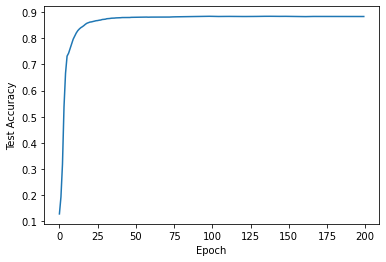

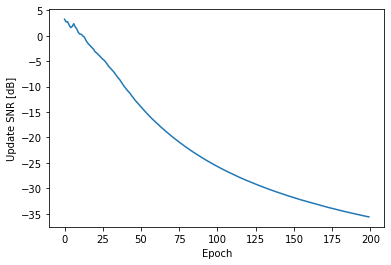

In [17]:
train_acc_history = np.load(PATH_ACC+'.npy')
plt.plot(np.arange(epoch_max), train_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

update_rho_history = np.load(PATH_RHO+'.npy')
plt.plot(np.arange(epoch_max), 10*np.log10(update_rho_history/noise_pow))
plt.xlabel('Epoch')
plt.ylabel('Update SNR [dB]')
plt.show()

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH_NET))
outputs = net(images.cpu())

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 88.34 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 96.22 %
Accuracy of 1 : 97.09 %
Accuracy of 2 : 91.38 %
Accuracy of 3 : 86.63 %
Accuracy of 4 : 93.58 %
Accuracy of 5 : 86.32 %
Accuracy of 6 : 81.42 %
Accuracy of 7 : 84.63 %
Accuracy of 8 : 83.16 %
Accuracy of 9 : 81.47 %


In [21]:
print('Number of total devices: ', dev_num)
print('Distance of device %d: '%(dev_num-1), dev_dist[dev_num-1])
print('Sub-channel activation ratio of device %d: '%(dev_num-1), np.sum(P_alloc>0)/B)
print('Remaining powers of device %d: '%(dev_num-1), P-np.sum(P_alloc))

Number of total devices:  25
Distance of device 24:  149.3684804164992


NameError: name 'P_alloc' is not defined